# Goal of this notebook

Develop a training loop for finetuning ASR models using TTS loss by recreating RL training found in RL4LMs/rl4lms/envs/text_generation/training_utils.py

```bash
conda activate speller
cd /home/s1785140/rlspeller
```

In [130]:
print("this notebook is alive!!!")

this notebook is alive!!!


# automatic reloading magic

In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# imports

In [132]:
import torch
from typing import List, Dict, Tuple, Any
import hyperpyyaml
from tqdm import tqdm
from torchaudio.models.decoder import ctc_decoder
from torch.nn.functional import softmax
import random
from jiwer import cer
import numpy as np
import speechbrain as sb
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import pickle
import torchaudio
from collections import Counter

## check if gpu available

In [133]:
# print hostname to make sure we are on correct node
disallowed_nodes = ['escience6']
import socket
hostname = socket.gethostname()
print(hostname)
node = hostname.split('.')[0]
if node in disallowed_nodes:
    raise ValueError(f"Running on disallowed node {node}!")

barre.inf.ed.ac.uk


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()
assert torch.cuda.is_available()

In [135]:
import os
os.getcwd()

'/disk/nfs/ostrom/s1785140/rlspeller'

# HPARAMS

In [136]:
inference_hparams = {
    "sentencepiece_model_path": "/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/Tokenizer/save/0_char.model",

    # 'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain_subsampling1x_nowhitespace.yaml',
    'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain_subsampling1x.yaml',
    # 'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain_subsampling2x.yaml',
    # 'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain.yaml', # 4x subsampling

    'sample_rate': 16000, # TODO this isn't used???
    
    ### Loading ASR model 
    'enable_dropout': False,
    # 'dropout_p': 0.0, # 0.15 is the default value in speechbrain
    'dropout_p': 0.05, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.15, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.3, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.5, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.99, # 0.15 is the default value in speechbrain
    
    ### filter ASR dataset by words in oov list
    "filter_by_per": True,
    "str_min_len_threshold": 8, # only keep wordtypes with more than this many characters
    "wordtypes_to_keep": 250, # max number of wordtypes to transribe
    "max_token_ids_per_wordtype": 1,

    
    ### TRANSCRIBING AUDIO USING PRETRAINED ASR
    # FULL TEST RUN
    "batch_size": 64, # ASR batch size
    'num_asr_iterations': 1, # only increase over 1 if dropout is enabled at eval time
    'num_batches_to_transcribe': None, # transcribe all batches dataset
    'max_hyps_per_sample': None, 
    "beamsearch_nbest": 1000, # how many hyps per input audio
    "beamsearch_beam_size": 2000,
    "beamsearch_beam_threshold": 50,
    
    # SMALL TEST RUN
    # "batch_size": 32, # for debug
    # 'num_asr_iterations': 1, # for debug
    # 'num_batches_to_transcribe': None, # for debug
    # "beamsearch_nbest": 100, # for debug
    # 'max_hyps_per_sample': None, # for debug
    
    # # FAST DEBUG
    # "batch_size": 64, # for debug
    # 'num_asr_iterations': 1, # for debug
    # 'num_batches_to_transcribe': None, # for debug
    # "beamsearch_nbest": 1, # for debug
    # 'max_hyps_per_sample': None, # for debug


    ### CACHE to avoid recompute
    'recompute_tts_caches': False,
    'spelling2tts_mel_cache': "/home/s1785140/rlspeller/caches/spelling2tts_mel_cache.pkl",
    'spelling2tts_mfcc_cache': "/home/s1785140/rlspeller/caches/spelling2tts_mfcc_cache.pkl",
    'spelling2vocoded_audio_cache': "/home/s1785140/rlspeller/caches/spelling2vocoded_audio_cache.pkl",
    
    ### FASTPITCH INFERENCE
    'fastpitch_inference_batch_size': 32,    
}

# TOKENIZER

In [137]:
# load pretrained tokenizer used to tokenizer ASR training inputs 
import sentencepiece as spm 
spm_path = inference_hparams["sentencepiece_model_path"]
sp = spm.SentencePieceProcessor()
sp.load(spm_path)
print(sp.vocab_size())

28


In [138]:
# test tokenizer
s = "hello world my name is jason"
# TODO pass string through text cleaners? 
encoded = sp.EncodeAsIds(s)
assert 0 not in encoded, "tried to encode an unknown character"
print(" ".join(str(idx) for idx in encoded))

1 10 2 12 12 4 1 17 4 9 12 11 1 16 20 1 6 5 16 2 1 7 8 1 26 5 8 4 6


In [139]:
sp.DecodeIds(encoded)

'hello world my name is jason'

# NEW! SIMPLE TOKENIZER

In [140]:
from speechbrain.tokenizers.SimpleTokenizer import SimpleTokenizer

In [141]:
tokenizer = SimpleTokenizer()

In [142]:
text = "hello my name is jason"
text = text.replace(' ', '|')
print(text)
ids = tokenizer.encode_as_ids(text)
ids

hello|my|name|is|jason


[9, 6, 13, 13, 16, 1, 14, 26, 1, 15, 2, 14, 6, 1, 10, 20, 1, 11, 2, 20, 16, 15]

In [143]:
tokenizer.decode_ids(ids)

'hello|my|name|is|jason'

## test simple tokenizer with probability distribution, and see if CTC decoder successfully generates n-best lists

In [144]:
# create empty array of correct dimensions
min_len, max_len = 50, 100
bsz = 4
lens = torch.randint(min_len, max_len, (bsz,))
vocab_size = len(tokenizer.vocab)

# randomly assign probaility distribution to each timestep

# try to decode

In [145]:
randn = torch.randn(bsz, max_len, vocab_size)

In [146]:
ctc_probs = softmax(randn, dim=1)
# ctc_probs

In [147]:
ctc_beamsearch_decoder_test = ctc_decoder(
    lexicon=None,
    # tokens="/home/s1785140/rlspeller/templates/speech_recognition_CharTokens_NoLM/Tokenizer/save/tokens.txt",
    tokens=tokenizer.vocab,
    nbest=2,
    blank_token='-',
    sil_token="|",
)

predicted_ids = ctc_beamsearch_decoder_test(ctc_probs, lens)

predicted_words = []
for i, hyps in enumerate(predicted_ids):
    for j, hyp in enumerate(hyps):
        words = tokenizer.decode_ids(hyp.tokens.tolist()).split(" ")
        tup = (f"sample {i+1}, hyp {j+1}/{len(hyps)}", words)
        predicted_words.append(tup)
        print(tup)

('sample 1, hyp 1/2', ['|plaoagwlygbos|iamvlqdfsuyrertkuzocsndhxvtgrbfoeomcxzotcxequgedp|znfmjibydvj|'])
('sample 1, hyp 2/2', ['|plhoagwlygbos|iamvlqdfsuyrertkuzocsndhxvtgrbfoeomcxzotcxequgedp|znfmjibydvj|'])
('sample 2, hyp 1/2', ['|jxflzhvxogcglbahehlawdhf|tmwyqfsnidgysxcsluteifaqkengobord|'])
('sample 2, hyp 2/2', ['|axflzhvxogcglbahehlawdhf|tmwyqfsnidgysxcsluteifaqkengobord|'])
('sample 3, hyp 1/2', ['|ivqbnowywlqneugepbcwkxfopfmrwzndanjspgchgoigearshnt|ywk|hodtu|'])
('sample 3, hyp 2/2', ['|ivqbnowywlqnugepbcwkxfopfmrwzndanjspgchgoigearshnt|ywk|hodtu|'])
('sample 4, hyp 1/2', ['|hjbgqpcynw|askxhlpwsf|emomplvrxarktlipd|ejiacbkecvzayzpfcoimxfkgdqlvy|rgsurio|'])
('sample 4, hyp 2/2', ['|hjbgqpcynw|askxhlpwsf|emomplvrxarktlipd|ejhacbkecvzayzpfcoimxfkgdqlvy|rgsurio|'])


# LOAD ASR (PRETRAINED)

In [148]:
from templates.speech_recognition_CharTokens_NoLM.ASR.train import ASR
from templates.speech_recognition_CharTokens_NoLM.ASR.train import dataio_prepare
from torch.utils.data import DataLoader
from speechbrain.dataio.dataloader import LoopedLoader

In [149]:
# Load hyperparameters file with command-line overrides
speechbrain_hparams_file = inference_hparams['speechbrain_hparams_file']
with open(speechbrain_hparams_file) as f:
    speechbrain_hparams = hyperpyyaml.load_hyperpyyaml(f)

/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/rirs_noises.zip exists. Skipping download


In [150]:
# overrides
if 'batch_size' in inference_hparams:
    speechbrain_hparams['batch_size'] = inference_hparams['batch_size']
    speechbrain_hparams['train_dataloader_opts']['batch_size'] = inference_hparams['batch_size']
    speechbrain_hparams['valid_dataloader_opts']['batch_size'] = inference_hparams['batch_size']
    speechbrain_hparams['test_dataloader_opts']['batch_size'] = inference_hparams['batch_size']
    speechbrain_hparams['allsplits_dataloader_opts']['batch_size'] = inference_hparams['batch_size']

In [151]:
speechbrain_hparams['save_folder']

'/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/ASR/results/CRDNN_CHAR_LJSpeech_halved_subsampling1x/2602/save'

In [152]:
# replace some values with inference time values
speechbrain_hparams['dropout'] = inference_hparams['dropout_p']

In [153]:
# initialise trainer (we don't want to train, but model is tightly coupled with trainer)
asr_brain = ASR(
    modules=speechbrain_hparams["modules"],
    opt_class=speechbrain_hparams["opt_class"],
    hparams=speechbrain_hparams,
    checkpointer=speechbrain_hparams["checkpointer"],
)

In [154]:
def change_dropout_p(brain, new_dropout_p):
    for module_name in brain.modules.keys():
        module = brain.modules[module_name]
        for submodule_name, submodule in module.named_modules():
            if isinstance(submodule, torch.nn.Dropout) or isinstance(submodule, torch.nn.Dropout2d):
                # handle proper dropout submodules
                print(f"changed dropout p of {module_name}-{submodule_name}-{submodule} from {submodule.p} to {new_dropout_p}")
                submodule.p = new_dropout_p
            else:
                # handle dropout in nn.LSTM
                for attr in ["dropout", "drop"]:
                    if hasattr(submodule, attr) and type(getattr(submodule, attr)) == float: 
                        print(f"changed dropout p of {module_name}-{submodule_name}-{submodule} from {getattr(submodule, attr)} to {new_dropout_p}")
                        setattr(submodule, attr, new_dropout_p)

def setup_asr_brain_for_infer(asr_brain, enable_dropout=False, new_dropout_p=0.15):
    asr_brain.on_evaluate_start(min_key="WER") # We call the on_evaluate_start that will load the best model
    if enable_dropout:
        asr_brain.modules.train()
        print("Enabled dropout in model:")
        change_dropout_p(asr_brain, new_dropout_p)
    else:
        asr_brain.modules.eval() # We set the model to eval mode (remove dropout etc)

print("if on_evaluate_start() get runtime error, likely need to restart notebook kernel")
setup_asr_brain_for_infer(asr_brain, enable_dropout=inference_hparams["enable_dropout"], new_dropout_p=inference_hparams["dropout_p"])

if on_evaluate_start() get runtime error, likely need to restart notebook kernel


In [155]:
# create dataset and dataloader for inference
datasets = dataio_prepare(speechbrain_hparams)

test_set = datasets['test']

if not isinstance(test_set, DataLoader) or isinstance(test_set, LoopedLoader):
    test_loader_kwargs=speechbrain_hparams["test_dataloader_opts"]
    test_set = asr_brain.make_dataloader(
        test_set, stage=sb.Stage.TEST, **test_loader_kwargs
    )

In [156]:
# get vocab from tokenizer (needed for ctc decoding)
vocab_size = len(asr_brain.hparams.tokenizer)
vocab = []
for i in range(vocab_size):
    vocab.append(asr_brain.hparams.tokenizer.decode_ids([i]))
print(vocab)

# edit vocab to match default ctc decoder symbols for blank and silence
vocab[0] = '-'
vocab[1] = "|"

print(vocab)

[' ⁇ ', '', 'e', 't', 'o', 'a', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'c', 'f', 'u', 'm', 'w', 'p', 'g', 'y', 'b', 'v', 'k', 'x', 'q', 'j', 'z']
['-', '|', 'e', 't', 'o', 'a', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'c', 'f', 'u', 'm', 'w', 'p', 'g', 'y', 'b', 'v', 'k', 'x', 'q', 'j', 'z']


In [157]:
ctc_beamsearch_decoder = ctc_decoder(
    lexicon=None,
    # tokens="/home/s1785140/rlspeller/templates/speech_recognition_CharTokens_NoLM/Tokenizer/save/tokens.txt",
    tokens=vocab,
    nbest=inference_hparams['beamsearch_nbest'],
    beam_size=inference_hparams['beamsearch_beam_size'],
    beam_threshold=inference_hparams['beamsearch_beam_threshold'],
    blank_token='-',
    sil_token="|",
)

In [158]:
# generate transcriptions for all batches in test set
def transcribe_dataset(asr_brain, dataset, greedy=False, num_batches_to_transcribe=None):
    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():
        transcripts = []
        for batch in tqdm(list(dataset)[:num_batches_to_transcribe], dynamic_ncols=True):
            orig_transcriptions = batch.words

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            predictions = asr_brain.compute_forward(batch, stage=sb.Stage.TEST)
            
            ctc_probs = predictions['ctc_logprobs'] # FOR DEBUG

            if greedy:
                predicted_ids = sb.decoders.ctc_greedy_decode(
                    predictions["ctc_logprobs"], asr_brain.feat_lens, blank_id=asr_brain.hparams.blank_index
                )
                predicted_words = [
                    asr_brain.tokenizer.decode_ids(ids).split(" ")
                    for ids in predicted_ids
                ]
            else:
                # get mel lens from wav len ratios since torch ctc decoder requires lens in frames
                batch_max_len = predictions["ctc_logprobs"].size(1)
                bsz = predictions["ctc_logprobs"].size(0)
                mel_lens = torch.zeros(bsz)
                for i, len_ratio in enumerate(asr_brain.feat_lens):
                    mel_lens[i] = int(torch.round(len_ratio * batch_max_len))
                
                predicted_ids = ctc_beamsearch_decoder(
                    predictions["ctc_logprobs"], lengths=mel_lens
                )

                predicted_words = []
                for i, (utt_id, orig_text, hyps) in enumerate(zip(batch.utt_id, orig_transcriptions, predicted_ids)):
                    print(f"\nsample {i+1} - ({utt_id}: '{orig_text}')")
                    sample_cers = []
                    for j, hyp in enumerate(hyps):
                        words = asr_brain.hparams.tokenizer.decode_ids(hyp.tokens.tolist()) # .split("|")
                        # words = tokenizer.decode_ids(hyp.tokens.tolist()) # .split("|")
                        hyp_cer = 100 * cer(orig_text, words)
                        sample_cers.append(hyp_cer)
                        print(f"\thyp {j+1}/{len(hyps)} (CER={hyp_cer:.1f}%): '{words}'")
                        predicted_words.append((f"sample {i+1}, hyp {j+1}/{len(hyps)}", words))
                        
                    print(f"\t=== Mean CER: {np.mean(sample_cers):.1f}%, Std CER: {np.std(sample_cers):.1f}% ===")

            transcripts.append(predicted_words)

    return transcripts, ctc_probs

# transcripts, ctc_probs = transcribe_dataset(asr_brain, test_set, greedy=False, num_batches_to_transcribe=1)

# LOAD WORD ALIGNED WAVS into dataset

In [159]:
# imitate CLAs
import sys
import argparse
import math
import glob
from tqdm import tqdm
import json

In [160]:
# set these in yaml config!

# these are to be loaded!
train_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_train_wordtoken_wav_annotation.json'
valid_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_valid_wordtoken_wav_annotation.json'
test_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_test_wordtoken_wav_annotation.json'

# this will be saved!
allsplits_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_allsplits_wordtoken_wav_annotation.json'

In [161]:
# create a new "combined annotation", that includes all of train, valid and test
def load_json(p):
    with open(p) as f:
        d = json.load(f)
    return d

allsplits_d = {}
for p in [train_annotation_path, valid_annotation_path, test_annotation_path]:
    allsplits_d.update(load_json(p))
    
json_data = json.dumps(allsplits_d)
with open(allsplits_annotation_path, 'w') as f:
    f.write(json_data)

In [162]:
speechbrain_hparams['train_annotation'] = train_annotation_path
speechbrain_hparams['valid_annotation'] = valid_annotation_path
speechbrain_hparams['test_annotation'] = test_annotation_path
speechbrain_hparams['allsplits_annotation'] = allsplits_annotation_path

In [163]:
def dataio_prepare(
    hparams, 
    split2data=None # use to optionally initialise datasets from data dicts rather than json files
):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    # wav path like: data/ljspeech_wavs_16khz_word_aligned/differs/differs__LJ001-0001__occ1__len8320.wav
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig", "wav_path", "utt_id")
    def audio_pipeline(wav_path):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav_path)
        yield sig

        yield wav_path

        utt_id = wav_path.split("/")[-1].split(".")[0]
        yield utt_id

    @sb.utils.data_pipeline.takes("samples_to_graphemes_ratio")
    @sb.utils.data_pipeline.provides("samples_to_graphemes_ratio")
    def ratio_pipeline(samples_to_graphemes_ratio):
        yield samples_to_graphemes_ratio

    @sb.utils.data_pipeline.takes("length")
    @sb.utils.data_pipeline.provides("length")
    def length_pipeline(length):
        yield length

    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides("words")
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels

        NB Make sure that you yield exactly what is defined above in @sb.utils.data_pipeline.provides()"""
        yield words

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}

    load_annotations_from_json_files = split2data is None
    if load_annotations_from_json_files:
        # by default load all splits from the json files specified in hparams
        data_info = {
            "train": hparams["train_annotation"],
            "valid": hparams["valid_annotation"],
            "test": hparams["test_annotation"],
            "allsplits": hparams["allsplits_annotation"],
        }
    else:
        data_info = split2data
        
    for split in data_info:
        print(f"create Dataset from split {split}")
        if load_annotations_from_json_files:
            constructor = sb.dataio.dataset.DynamicItemDataset.from_json
        else:
            constructor = sb.dataio.dataset.DynamicItemDataset
            
        datasets[split] = constructor(
            data_info[split],
            dynamic_items=[audio_pipeline, ratio_pipeline, length_pipeline, text_pipeline],
            output_keys = [
                "id",
                "sig",
                "wav_path",
                "utt_id",
                "samples_to_graphemes_ratio",
                "length",
                "words",
            ],
        )
        hparams[f"{split}_dataloader_opts"]["shuffle"] = True
        datasets[split].split = split # add attribute to keep track of the split of the dataset

    def print_dataset_lens(extra_str):
        for split in data_info:
            dataset_split = datasets[split]
            print(f"{split} dataset has {len(dataset_split)} samples", extra_str)

    print_dataset_lens("before any filtering")

    # Filter data for samples_to_graphemes_ratio that is either too small or too large
    key_min_value = {}
    if hparams["min_samples_to_graphemes_ratio"] is not None:
        key_min_value = {"samples_to_graphemes_ratio": hparams["min_samples_to_graphemes_ratio"]}

    key_max_value = {}
    if hparams["max_samples_to_graphemes_ratio"] is not None:
        key_max_value = {"samples_to_graphemes_ratio": hparams["max_samples_to_graphemes_ratio"]}

    for split in data_info:
        datasets[split] = datasets[split].filtered_sorted(
            key_min_value=key_min_value,
            key_max_value=key_max_value,
        )
    print_dataset_lens("after filtering by min and max samples to graphemes ratio")

    # Filter samples whos length is too short
    key_min_value = {}
    if hparams["min_length_seconds"] is not None:
        key_min_value = {"length": hparams["min_length_seconds"]}
    for split in data_info:
        datasets[split] = datasets[split].filtered_sorted(
            key_min_value=key_min_value,
        )
    print_dataset_lens("after filtering by minimum length")

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if load_annotations_from_json_files:
        if hparams["sorting"] == "ascending":
            datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
            hparams["train_dataloader_opts"]["shuffle"] = False

        elif hparams["sorting"] == "descending":
            datasets["train"] = datasets["train"].filtered_sorted(
                sort_key="length", reverse=True
            )
            hparams["train_dataloader_opts"]["shuffle"] = False

        elif hparams["sorting"] == "random":
            hparams["train_dataloader_opts"]["shuffle"] = True
            pass

        else:
            raise NotImplementedError(
                "sorting must be random, ascending or descending"
            )
    
    return datasets

## filter dataset by PER of wordtypes as predicted by RNN-based G2P model

In [164]:
p = '/home/s1785140/data/ljspeech_fastpitch/oov_list_with_PER.pickle'
str_min_len_threshold = 0 
N = 400
per_df = pd.read_pickle(p)
per_df = per_df[per_df['wordtype'].str.len() >= str_min_len_threshold]
per_df = per_df.sort_values('per', ascending=False)
per_df.head(N)

,wordtype,lexicon_entry,predicted_phnseq,per
7954,ah,[AA],"[AH, HH]",2.000000
4168,deutsche,"[D, OY, CH]","[D, IH, UW, T, S, K, IY]",2.000000
7874,nux,"[N, UW]","[N, AH, K, S]",1.500000
4423,jacques,"[ZH, AA, K]","[JH, AH, K, W, Z]",1.333333
6791,chaos,"[K, EY, AA, S]","[CH, AE, OW, Z]",1.000000
...,...,...,...,...
3388,burchell,"[B, ER, K, AH, L]","[B, ER, CH, EH, L]",0.400000
4665,sneered,"[S, N, IH, R, D]","[S, N, AH, ER, D]",0.400000
3636,outshone,"[AW, T, SH, OW, N]","[AW, T, S, AA, N]",0.400000
5931,garret,"[G, EH, R, IH, T]","[G, AE, R, AH, T]",0.400000


In [165]:
def filter_data_by_per(data, str_min_len_threshold, N, max_token_ids_per_wordtype):
    p = '/home/s1785140/data/ljspeech_fastpitch/oov_list_with_PER.pickle'
    loaded_df = pd.read_pickle(p)
    loaded_df = loaded_df[loaded_df['wordtype'].str.len() >= str_min_len_threshold]
    loaded_df = loaded_df.sort_values('per', ascending=False).head(N)
    wordtypes_to_keep = set(loaded_df['wordtype'])
    new_data = {}
    wordtype2tokenid_count = Counter()
    for token_id, token_id_values in data.items():
        wordtype = token_id_values['words']
        if wordtype not in wordtypes_to_keep or wordtype2tokenid_count[wordtype] >= max_token_ids_per_wordtype:
            continue
        new_data[token_id] = token_id_values
        wordtype2tokenid_count[wordtype] += 1
    return new_data

def filter_data_by_exclusionlist(data, words_to_exclude):
    new_data = {}
    for token_id, token_id_values in data.items():
        wordtype = token_id_values['words']
        if wordtype not in words_to_exclude:
            new_data[token_id] = token_id_values
    return new_data

bad_alignments = [
    'subpoenaed',
    'deprecated',
    'habitually',
    'hogshead',
    'schleiden',
    'sabotage',
    'schoeffer',
] 

filter_by_per = inference_hparams["filter_by_per"]

# load from json files
if not filter_by_per:
    datasets = dataio_prepare(speechbrain_hparams)
else:
    filtered_allsplits_d = filter_data_by_per(allsplits_d, str_min_len_threshold=inference_hparams["str_min_len_threshold"], 
                                              N=inference_hparams["wordtypes_to_keep"], max_token_ids_per_wordtype=inference_hparams['max_token_ids_per_wordtype'])
    filtered_allsplits_d = filter_data_by_exclusionlist(filtered_allsplits_d, bad_alignments)
    datasets = dataio_prepare(speechbrain_hparams, {'allsplits': filtered_allsplits_d})

create Dataset from split allsplits
allsplits dataset has 246 samples before any filtering
allsplits dataset has 246 samples after filtering by min and max samples to graphemes ratio
allsplits dataset has 246 samples after filtering by minimum length


In [166]:
# create tokenid2wavpath dict
tokenid2wavpath = {token_id: allsplits_d[token_id]['wav'] for token_id in allsplits_d.keys()}

In [167]:
# convert from datasets to dataloaders
split2stage = {"train": sb.Stage.TRAIN, "valid": sb.Stage.VALID, "test": sb.Stage.TEST, "allsplits": sb.Stage.TEST}
for split in datasets.keys():
    if not isinstance(datasets[split], DataLoader) or isinstance(datasets[split], LoopedLoader):
        dataloader_kwargs=speechbrain_hparams[f"{split}_dataloader_opts"]
        datasets[split] = asr_brain.make_dataloader(
            datasets[split], stage=split2stage[split], **dataloader_kwargs
        )

In [168]:
def set_whitespace_to_0_probability(ctc_probs, vocab, log_probs=True, whitespace_symbol="|"):
    """ctc_probs [bsz, max_seq_len, vocab_size]"""
    new_probability = -math.inf if log_probs else 0.0
    ctc_probs[:,:,vocab.index(whitespace_symbol)] = new_probability
    return ctc_probs

# TRANSCRIBE WORD ALIGNED WAVS

In [169]:
from collections import defaultdict

# generate transcriptions for all batches in test set
def transcribe_dataset(asr_brain, dataset, 
                       num_batches_to_transcribe=None,
                       hack_whitespace_probs=False, collapse_whitespace=True,
                       print_info=False, max_hyps_per_sample=None,
                       wordtypes_to_transcribe=[]):
    # Now we iterate over the dataset and we simply compute_forward and decode

    orig_words = []
    printouts = []
    orig_wavs = []
    token_ids = []
    transcribed_words = defaultdict(list)
    n = 0 # number of batches transcribed
    
    break_forloop_early = num_batches_to_transcribe is not None

    with torch.no_grad():
        for batch in tqdm(dataset, dynamic_ncols=True, total=num_batches_to_transcribe):
            # break out of loop if we have transcribed enough batches
            if break_forloop_early and n >= num_batches_to_transcribe:
                break
            n += 1

            orig_transcriptions = batch.words
            wavs = batch.sig.data

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            predictions = asr_brain.compute_forward(batch, stage=sb.Stage.TEST)
            ctc_probs = predictions['ctc_logprobs'] # FOR DEBUG

            # hack probabilities to set all probs to 0 for whitespace
            if hack_whitespace_probs:
                ctc_probs = set_whitespace_to_0_probability(ctc_probs, vocab, log_probs=True, whitespace_symbol="|")

            # get mel lens from wav len ratios since torch ctc decoder requires lens in frames
            batch_max_len = predictions["ctc_logprobs"].size(1)
            bsz = predictions["ctc_logprobs"].size(0)
            mel_lens = torch.zeros(bsz)
            for i, len_ratio in enumerate(asr_brain.feat_lens):
                mel_lens[i] = int(torch.round(len_ratio * batch_max_len))
            
            predicted_ids = ctc_beamsearch_decoder(
                predictions["ctc_logprobs"], lengths=mel_lens
            )

            # iterate over samples in batch
            for i, (utt_id, orig_text, hyps, wav) in enumerate(zip(batch.utt_id, orig_transcriptions, predicted_ids, wavs)):
                sample_printout = f"\nsample {i+1} - ({utt_id}: '{orig_text}')"
                orig_utt_text = "INSERT ORIG UTT TEXT"
                sample_printout += f"\nOriginal Utterance: {orig_utt_text}"
                # if print_info: print(f"\nsample {i+1} - ({utt_id}: '{orig_text}')")
                sample_cers = []
                for j, hyp in enumerate(list(hyps)[:max_hyps_per_sample]):
                    words = asr_brain.hparams.tokenizer.decode_ids(hyp.tokens.tolist())
                    if collapse_whitespace:
                        words = "".join(c for c in words if c != " ")
                    hyp_cer = 100 * cer(orig_text, words)
                    sample_cers.append(hyp_cer)
                    sample_printout += f"\n\thyp {j+1}/{len(hyps)} (CER={hyp_cer:.1f}%): '{words}'"
                    # if print_info: print(f"\thyp {j+1}/{len(hyps)} (CER={hyp_cer:.1f}%): '{words}'")
                    if not wordtypes_to_transcribe or orig_text in wordtypes_to_transcribe:
                        transcribed_words[orig_text].append(words)
                    
                sample_printout += f"\n\t=== Mean CER: {np.mean(sample_cers):.1f}%, Std CER: {np.std(sample_cers):.1f}% ==="
                # if print_info: print(f"\t=== Mean CER: {np.mean(sample_cers):.1f}%, Std CER: {np.std(sample_cers):.1f}% ===")

                include_current_wordtype = (wordtypes_to_transcribe == [] or orig_text in wordtypes_to_transcribe)
                if include_current_wordtype:
                    orig_words.append(orig_text)
                    printouts.append(sample_printout)
                    orig_wavs.append(wav)
                    token_ids.append(utt_id)

    output_dict = {
        "orig_words": orig_words,
        "transcribed_words": transcribed_words,
        "wavs": orig_wavs,
        "printouts": printouts,
        "token_ids": token_ids,
    }

    return output_dict


## Generate multiple times to see if outputs change (i.e. should change if dropout is enabled in model)

In [170]:
wordtypes_to_transcribe = []
# wordtypes_to_transcribe = ['anesthesiologists'] # used for debugging and checking results only for a subset of wordtypes

word_sets = defaultdict(set)

print_printout = False
display_audio = False

'''create output dict of form:
token_id:
    word: xxx
    hyps:
        xxx
        xxx
        xxx
        ...
    wav: /path/to/token_id.wav
'''
token_id2gt_audio = {}
master_transcription_dict = defaultdict(dict)
print_num_new_spellings_per_iteration = False

for i in range(inference_hparams['num_asr_iterations']):
    random.seed(i)
    torch.random.manual_seed(i)
    np.random.seed(i)
    
    print(f"Iteration {1+i}/{inference_hparams['num_asr_iterations']}")
    transcription_output_dict = transcribe_dataset(asr_brain, datasets["allsplits"], 
                                                num_batches_to_transcribe=inference_hparams['num_batches_to_transcribe'],
                                                collapse_whitespace=False, hack_whitespace_probs=True,
                                                max_hyps_per_sample=inference_hparams['max_hyps_per_sample'],
                                                wordtypes_to_transcribe=wordtypes_to_transcribe)
    
    for token_id, orig_word, printout, wav in zip(
        transcription_output_dict["token_ids"], 
        transcription_output_dict["orig_words"], 
        transcription_output_dict["printouts"], 
        transcription_output_dict["wavs"]
    ):
        if print_printout:
            print(printout)
        if display_audio:
            display(Audio(wav, rate=16000))
        old_count = len(word_sets[orig_word])
        asr_hypotheses = transcription_output_dict["transcribed_words"][orig_word]
        asr_hypotheses = [hyp.rstrip() for hyp in asr_hypotheses] # as CTC decoder always adds extra whitespace to end
        word_sets[orig_word].update(asr_hypotheses)
        master_transcription_dict[token_id]["orig_word"] = orig_word
        
        wav_path = tokenid2wavpath[token_id]
        master_transcription_dict[token_id]["orig_wav"] = wav_path
        token_id2gt_audio[token_id] = wav_path
        
        if "hyps" not in master_transcription_dict[token_id]:
            master_transcription_dict[token_id]["hyps"] = set(asr_hypotheses)
        else:
            master_transcription_dict[token_id]["hyps"].update(asr_hypotheses)
        
        new_count = len(word_sets[orig_word])
        if new_count > old_count:
            if print_num_new_spellings_per_iteration:
                print(f"added {new_count - old_count} new spellings for '{orig_word}' to its word set")

total_num = 0
for orig_word, word_set in word_sets.items():
    print(f"added {len(word_set)} new spellings for '{orig_word}' to its word set")
    total_num += len(word_set)
    
print(f"\n *** Will synthesise these {total_num} spellings using TTS pipeline")

Iteration 1/1


100%|███████████████████████████████████████████████████████| 4/4 [05:20<00:00, 80.14s/it]


added 1000 new spellings for 'conducive' to its word set
added 1000 new spellings for 'patriotic' to its word set
added 1000 new spellings for 'exertion' to its word set
added 1000 new spellings for 'exhaustion' to its word set
added 1000 new spellings for 'soubriquet' to its word set
added 1000 new spellings for 'borsippa' to its word set
added 1000 new spellings for 'minorities' to its word set
added 1000 new spellings for 'fatigues' to its word set
added 1000 new spellings for 'narcotics' to its word set
added 1000 new spellings for 'monitored' to its word set
added 1000 new spellings for 'discouraging' to its word set
added 1000 new spellings for 'spirituous' to its word set
added 1000 new spellings for 'czolgosz' to its word set
added 1000 new spellings for 'psychiatrist' to its word set
added 1000 new spellings for 'brochure' to its word set
added 1000 new spellings for 'juveniles' to its word set
added 1000 new spellings for 'ostentatious' to its word set
added 1000 new spelling

# create dataframe to store respellings (and respective CERs) and original spellings 

In [171]:
# create big dataframe to hold all data
df = pd.DataFrame(columns=['token_id', 'wordtype', 'respelling', 'cer'])
data = [] # used to populate pandas dataframe

for token_id in tqdm(master_transcription_dict):    
    for i, hyp in enumerate(master_transcription_dict[token_id]['hyps'], 1):
        per = per_df[per_df['wordtype'] == master_transcription_dict[token_id]['orig_word']]['per'].values[0]
        data.append({'token_id': token_id, 
                     'wordtype': master_transcription_dict[token_id]['orig_word'], 
                     'respelling': hyp, 
                     'orig_wav': master_transcription_dict[token_id]['orig_wav'],
                     'cer': 100*cer(master_transcription_dict[token_id]['orig_word'], hyp),
                     'per': per,
                     'asr_nbest_rank':i}),

df = pd.concat([df, pd.DataFrame(data)])
print('number of token_id-spelling combinations', len(df))

number of token_id-spelling combinations 246000


In [172]:
# guarantee that original spelling will be generated by TTS
# i.e. add orig_word to "respelling" column if it doesn't occur in it already
dfs_to_concat = []
for orig_word in df['wordtype'].unique():
    match_mask = df['respelling'] == orig_word
    matching_respellings = df.loc[match_mask]
    if matching_respellings.empty:
        # copy the first row, but change value for respelling
        first_row_df = df.loc[df['wordtype'] == orig_word].head(1)
        row_idx = first_row_df.index[0]
        first_row_df.loc[row_idx, 'respelling'] = orig_word
        first_row_df.loc[row_idx, 'cer'] = 0.0
        dfs_to_concat.append(first_row_df)
        # print(f'added original spelling to respelling column for "{orig_word}"')

for temp_df in dfs_to_concat:
    df = pd.concat([df, temp_df], ignore_index=True)
print('number of token_id-spelling combinations', len(df))

number of token_id-spelling combinations 246122


# create mapping from token_id to ground truth fastpitch mels and MFCCs

In [173]:
#build mapping from token_id to path to its gt word aligned mel 
word_aligned_feats_path = '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels_lowercase_nopunc'
token_id2fastpitch_gt_mel_path = {}

for token_id in df['token_id'].unique():
    wordtype = token_id.split('__')[0]
    path = os.path.join(word_aligned_feats_path, wordtype, token_id + '.pt')
    token_id2fastpitch_gt_mel_path[token_id] = path

In [174]:
# load mels from disk
token_id2fastpitch_gt_mel = {}

for token_id, gt_mel_path in tqdm(token_id2fastpitch_gt_mel_path.items()):
    # remove len and file extension from path
    # e.g. 'wordaligned_mels/unconstitutionality/unconstitutionality__LJ021-0191__occ1__len25760.wav' 
    # ---> 'wordaligned_mels/unconstitutionality/unconstitutionality__LJ021-0191__occ1"
    path_no_len_no_ext = gt_mel_path.split('__len')[0]
    
    # glob to fine the matching ground truth mel saved on disk
    matches = glob.glob(path_no_len_no_ext + '*.pt')
    assert len(matches) == 1
    fastpitch_gt_mel = torch.load(matches[0]).transpose(0,1).cpu().numpy()
    token_id2fastpitch_gt_mel[token_id] = fastpitch_gt_mel
    
def melspec2mfcc(mel, n_mfcc=12):
    """fastpitch produces mel spectrograms
    upon looking at https://librosa.org/doc/main/_modules/librosa/feature/spectral.html#mfcc
            if S is None:
                # multichannel behavior may be different due to relative noise floor differences between channels
                S = power_to_db(melspectrogram(y=y, sr=sr, **kwargs))
    it seems you need to run the mel through amplitude_to_db before feeding to mfcc()"""
    log_mel = librosa.core.amplitude_to_db(mel, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_mel, n_mfcc=n_mfcc)
    return mfcc

token_id2fastpitch_gt_mfcc = {}
for token_id, fastpitch_gt_mel in tqdm(token_id2fastpitch_gt_mel.items()):
    token_id2fastpitch_gt_mfcc[token_id] = melspec2mfcc(fastpitch_gt_mel)  

100%|█████████████████████████████████████████████████| 246/246 [00:00<00:00, 2017.02it/s]


# load pretrained fastpitch and hifigan models

In [175]:
from load_pretrained_tts_and_vocoder import load_vocoder, load_pretrained_fastpitch

In [176]:
hifigan_checkpoint = "/home/s1785140/pretrained_models/hifigan/ljspeech/LJ_V1/generator_v1"
fastpitch_checkpoint = '/home/s1785140/respeller/fastpitch/exps/halved_ljspeech_data_nospaces_noeos_pad_lowercase_nopunc/FastPitch_checkpoint_1000.pt'

In [177]:
hifigan = load_vocoder(hifigan_checkpoint)

In [178]:
fastpitch, *_ = load_pretrained_fastpitch(fastpitch_checkpoint)

# load TTS+vocoder generation cache from disk

In [179]:
def load_cache(cache_path):
    if os.path.exists(cache_path):
        print("attempting to load cache at", cache_path)
        with open(cache_path, "rb") as f:
            cache = pickle.load(f)
        print("loaded cache at", cache_path)
    else:
        print("WARNING NO CACHE NOT FOUND AT", cache_path, 'returning empty one')
        cache = {}
    return cache

In [180]:
if inference_hparams['recompute_tts_caches']:
    if os.path.exists(inference_hparams['spelling2tts_mel_cache']):
        os.remove(inference_hparams['spelling2tts_mel_cache'])
    if os.path.exists(inference_hparams['spelling2tts_mfcc_cache']):
        os.remove(inference_hparams['spelling2tts_mfcc_cache'])
    if os.path.exists(inference_hparams['spelling2vocoded_audio_cache']):
        os.remove(inference_hparams['spelling2vocoded_audio_cache'])

spelling2tts_mel = load_cache(inference_hparams['spelling2tts_mel_cache'])
spelling2tts_mfcc = load_cache(inference_hparams['spelling2tts_mfcc_cache'])
spelling2vocoded_audio = load_cache(inference_hparams['spelling2vocoded_audio_cache'])

assert set(spelling2tts_mel.keys()) == set(spelling2tts_mfcc.keys()) == set(spelling2vocoded_audio.keys())

attempting to load cache at /home/s1785140/rlspeller/caches/spelling2tts_mel_cache.pkl
loaded cache at /home/s1785140/rlspeller/caches/spelling2tts_mel_cache.pkl
attempting to load cache at /home/s1785140/rlspeller/caches/spelling2tts_mfcc_cache.pkl
loaded cache at /home/s1785140/rlspeller/caches/spelling2tts_mfcc_cache.pkl
attempting to load cache at /home/s1785140/rlspeller/caches/spelling2vocoded_audio_cache.pkl
loaded cache at /home/s1785140/rlspeller/caches/spelling2vocoded_audio_cache.pkl


# run each respelling through TTS to get mel-spectrogram (and optionally vocode to get wav)

In [181]:
from fastpitch.inference import prepare_input_sequence

In [182]:
cached_spellings = list(spelling2tts_mel.keys())

In [183]:
# we only want to generate using TTS for words that are not already in our cache
mask = ~df["respelling"].isin(cached_spellings)
exclude_cached_spellings_df = df[mask]

In [184]:
exclude_cached_spellings_df

,token_id,wordtype,respelling,cer,orig_wav,per
0,conducive__LJ005-0086__occ1__len13120,conducive,toconducive,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000
1,conducive__LJ005-0086__occ1__len13120,conducive,iconducived,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000
2,conducive__LJ005-0086__occ1__len13120,conducive,heconducivedd,44.444444,/home/s1785140/speechbrain/templates/speech_re...,0.500000
3,conducive__LJ005-0086__occ1__len13120,conducive,consducived,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000
4,conducive__LJ005-0086__occ1__len13120,conducive,conducivevd,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000
...,...,...,...,...,...,...
246115,cemetery__LJ043-0058__occ1__len11360,cemetery,cemetery,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.375000
246116,salubrious__LJ019-0209__occ1__len17600,salubrious,salubrious,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.333333
246118,righteous__LJ012-0066__occ1__len9920,righteous,righteous,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.400000
246119,exhaustive__LJ006-0027__occ1__len11040,exhaustive,exhaustive,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.500000


In [185]:
# create input to fastpitch batch maker
all_orig_words = [orig_word for orig_word in exclude_cached_spellings_df['wordtype']]
all_respellings = [respelling for respelling in exclude_cached_spellings_df['respelling']]
fields = {'orig_spelling': all_orig_words, 
          'respelling': all_respellings,
          'text': all_respellings} # will be encoded by text processes into IDs

In [186]:
# create batches for fastpitch inference
batches = prepare_input_sequence(fields, device, input_type='char', 
                       symbol_set='english_pad_lowercase_nopunc', 
                       text_cleaners=['lowercase_no_punc'],
                       batch_size=inference_hparams['fastpitch_inference_batch_size'])

Loading texts: 100%|████████████████████████████| 241671/241671 [00:35<00:00, 6771.90it/s]


In [187]:
def generate_audio(y, vocoder=None, hop_length=256):
    """Generate audio from spectrograms for n utterances in batch"""
    mel, mel_lens = y
    bs = mel.size(0)
    with torch.no_grad():
        audios = vocoder(mel).cpu().squeeze(1).numpy() # [bsz, dim, samples ]only squeeze away dim (equals 1 for waveform)
        mel_lens = mel_lens.cpu().numpy() - 1
    audios_to_return = []
    for audio, mel_len in zip(audios, mel_lens):
        audio = audio[:mel_len * hop_length]
        audio = audio / np.max(np.abs(audio))
        audios_to_return.append(audio)
        
    return audios_to_return

In [188]:
do_vocode = True
audios = None

if batches:
    with torch.no_grad():
        for b in tqdm(batches, "synthesising respellings"):
            mel, mel_lens, *_ = fastpitch(b['text'])

            if do_vocode:
                vocoder_inputs = (mel, mel_lens)
                audios = generate_audio(vocoder_inputs, hifigan)

            # add samples in batch to dicts
            bsz = len(mel)
            for i in range(bsz):
                respelling = b['respelling'][i]
                mel_len = mel_lens[i]
                spelling2tts_mel[respelling] = mel[i, :, :mel_len].cpu().numpy() # mel [bsz, feats, time]
                spelling2tts_mfcc[respelling] = melspec2mfcc(spelling2tts_mel[respelling])

                if do_vocode and audios is not None:
                    spelling2vocoded_audio[respelling] = audios[i]
else:
    print("Warning! Nothing in batches, possibly because all spellings have been generated by TTS and then cached!!!")

synthesising respellings: 100%|███████████████████████| 7553/7553 [56:06<00:00,  2.24it/s]


In [189]:
# save new caches / updated caches to disk
with open(inference_hparams['spelling2tts_mel_cache'], 'wb') as f:
    pickle.dump(spelling2tts_mel, f)
print("finished dumping", inference_hparams['spelling2tts_mel_cache'])
with open(inference_hparams['spelling2tts_mfcc_cache'], 'wb') as f:
    pickle.dump(spelling2tts_mfcc, f)
print("finished dumping", inference_hparams['spelling2tts_mfcc_cache'])
with open(inference_hparams['spelling2vocoded_audio_cache'], 'wb') as f:
    pickle.dump(spelling2vocoded_audio, f)
print("finished dumping", inference_hparams['spelling2vocoded_audio_cache'])

## Encode TTS output into MFCC and Hubert representations (continuous and discrete)

In [190]:
def codes2centroids(code_seq):
    assert code_seq.dim() == 1
    centroids = hubert.kmeans.cluster_centers_
    centroid_seq = [centroids[code] for code in code_seq] 
    stacked_centroid_seq = np.stack(centroid_seq)
    assert stacked_centroid_seq.shape[0] == len(centroid_seq)
    return stacked_centroid_seq

In [191]:
resampler = torchaudio.transforms.Resample(orig_freq=22050,
                                           new_freq=16000).cuda()

def wav2ssl_feats(
    wav, 
    hubert_type,
    discrete_type,
    output_layer=7 # from paper (A COMPARISON OF DISCRETE AND SOFT SPEECH UNITS FOR IMPROVED VOICE CONVERSION)
):
    """
    returns numpy array of SSL features 
    
    size:
        [timesteps, feats]
        or [timesteps] for discrete codes
    """
    wav = torch.tensor(wav)
    assert wav.dim() == 1
    wav = wav.unsqueeze(0).unsqueeze(0).cuda()
    wav = resampler(wav)

    # Extract speech units
    if hubert_type == 'raw':
        feats = hubert.encode(wav, layer=output_layer)[0].detach().transpose(1,2)
    else: # discrete / soft
        feats = hubert.units(wav)
        if feats.dim() == 3:
            # soft features
            feats = feats.transpose(1,2)
        if hubert_type == 'discrete' and discrete_type == 'centroid':
            # convert from sequence of discrete codes to sequence of centroid vectors that correspond to the discrete codes
            feats = codes2centroids(feats).T

    # standardise feats by removing batch dimension, and converting to numpy arrays
    if type(feats) == torch.Tensor:
        feats = feats.cpu().numpy()
    if len(feats.shape) == 3: # likely [b_sz, timesteps, feats]
        # squeeze away batchsize dimension
        feats = np.squeeze(feats, axis=0)
        assert len(feats.shape) == 2
    
    return feats

## Add to the dataframe a path to each form of cached hubert features for each spelling

For each token_id and for each spelling, load cached hubert features from disk otherwise, encode using hubert then save to disk in cache folder

Cache directory hierarchy:

- cache/
    - hubert/
        - raw/
        - soft/
        - discrete/
            - code/
            - centroid/

In [213]:
cache_dir = "/home/s1785140/rlspeller/caches"

feats_to_use = [
    # ('mfcc', None, None),
    # ('hubert', 'raw', None),
    # ('hubert', 'soft', None),
    # ('hubert', 'discrete', 'code'),
    ('hubert', 'discrete', 'centroid'),
]

def feats2feats_col(feats):
    feat_col = feats[0]
    
    for descriptor in feats[1:]:
        if descriptor is not None:
            feat_col += f"-{descriptor}"
    
    gt_feat_col = feat_col + '-GT'
    return feat_col, gt_feat_col

def feats2feats_dir(feats):
    outdir = feats[0]
    
    for descriptor in feats[1:]:
        if descriptor is not None:
            outdir = os.path.join(outdir, descriptor)
    
    return outdir

def load_hubert_model(hubert_type):
    if hubert_type in ['soft']: # NB raw feats can be extracted from hubert_soft or discrete
        hubert = torch.hub.load("bshall/hubert:main", "hubert_soft").cuda() # input sample rate should be 16khz
    elif hubert_type in ['discrete', 'raw']:
        # NOTE FOR RAW, WE LOAD DISCRETE HUBERT NOT SOFT, THIS IS BECAUSE SOFT HUBERT HAS BEEN FINETUNED TO LEARN THE SOFT SPEECH UNITS
        hubert = torch.hub.load("bshall/hubert:main", "hubert_discrete").cuda() # input sample rate should be 16khz
    else:
        raise ValueError
    return hubert

for feats in feats_to_use:
    # create output directory to store caches
    outdir = os.path.join(cache_dir, feats2feats_dir(feats))    
    if not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)
    
    col_name, gt_col_name = feats2feats_col(feats)
    
    print(f"*** encoding spellings and GT audio using {col_name}")
        
    if col_name not in df.columns:
        # then add the column
        df[col_name] = None
    if gt_col_name not in df.columns:
        # add column for encoding of GT audio
        df[gt_col_name] = None
        
    feat_type, hubert_type, discrete_type = feats
     
    # load hubert model
    if feat_type == 'hubert':
        hubert = load_hubert_model(hubert_type)
        
    # check each spelling in df and check if hubert has been computed already
    def encode_column(input_audio_col_name, feats_col_name, input2audio_map):
        def do_encode(input_id, feats_col_name):
            """logic to determine if the input has been encoded before
            if there is None in any of the rows corresponding to this input id and feats col, then we need to generate"""
            if df[df[input_audio_col_name] == input_id][feats_col_name].apply(lambda x: x is None).any():
                return True
            return False
        
        # NOTE WARNING!!! Below code only works well if one token_id for each wordtype
        # TODO handle token_id differently as a token_id will be shared across many different respellings
            
        for input_id in tqdm(df[input_audio_col_name].unique(), desc=f"encoding {input_audio_col_name}"):
            if do_encode(input_id, feats_col_name):
                # encode and save to disk
                if type(input2audio_map[input_id]) == str:
                    wav, _sr = librosa.load(input2audio_map[input_id])
                else:
                    wav = input2audio_map[input_id]
                if feat_type == 'hubert':
                    encoding = wav2ssl_feats(wav, hubert_type, discrete_type)
                elif feat_type == 'mfcc':
                    if input_audio_col_name == 'respelling':
                        encoding = spelling2tts_mfcc[input_id]
                    elif input_audio_col_name == 'token_id':
                        encoding = token_id2fastpitch_gt_mfcc[input_id]
                else:
                    raise ValueError(f"invalid feat type {feat_type}" )
                save_path = os.path.join(outdir, f"{input_id}.npy")
                np.save(save_path, encoding)

                # enter save path into col for all matching rows
                for i in df[df[input_audio_col_name] == input_id][feats_col_name].index:
                    df.loc[i, feats_col_name] = save_path
                    
    encode_column('respelling', col_name, spelling2vocoded_audio)
    encode_column('token_id', gt_col_name, token_id2gt_audio)
    
print("!!! DONE !!!")

hubert = None # remove hubert model from memory

*** encoding spellings and GT audio using hubert-discrete-centroid


Using cache found in /home/s1785140/.cache/torch/hub/bshall_hubert_main
encoding token_id: 100%|██████████████████████████████████████████████| 246/246 [00:06<00:00, 37.48it/s]


!!! DONE !!!


In [214]:
df

,token_id,wordtype,respelling,cer,orig_wav,per,mfcc,mfcc-GT,hubert-raw,hubert-raw-GT,...,mfcc::Distance(Euclidean),mfcc::Distance(Euclidean)::w_SL_Penalty,hubert-raw::Distance(Cosine),hubert-raw::Distance(Cosine)::w_SL_Penalty,hubert-soft::Distance(Cosine),hubert-soft::Distance(Cosine)::w_SL_Penalty,hubert-discrete-code::Distance(Levenshtein),hubert-discrete-code::Distance(Levenshtein)::w_SL_Penalty,hubert-discrete-centroid::Distance(Cosine),hubert-discrete-centroid::Distance(Cosine)::w_SL_Penalty
0,conducive__LJ005-0086__occ1__len13120,conducive,toconducive,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/toconduci...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/toc...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,959.036613,1096.041843,16.546706,18.615045,8.664813,9.510160,18.0,19.756098,7.998631,8.778985
1,conducive__LJ005-0086__occ1__len13120,conducive,iconducived,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/iconduciv...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/ico...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1239.246208,1487.095449,22.935356,26.949043,14.554462,17.039370,27.0,31.609756,13.316780,15.590376
2,conducive__LJ005-0086__occ1__len13120,conducive,heconducivedd,44.444444,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/heconduci...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/hec...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1204.564791,1393.853544,28.895824,33.230198,22.590723,25.345689,34.0,38.146341,15.366240,17.240172
3,conducive__LJ005-0086__occ1__len13120,conducive,consducived,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/consduciv...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/con...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1418.388920,1843.905596,25.977098,33.120800,16.232254,20.587249,27.0,34.243902,13.548413,17.183353
4,conducive__LJ005-0086__occ1__len13120,conducive,conducivevd,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/con...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1462.096628,1754.515954,27.436162,32.237491,22.598137,26.456356,38.0,44.487805,19.251346,22.538161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246117,peripheral__LJ031-0066__occ1__len8960,peripheral,peripheral,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.571429,/home/s1785140/rlspeller/caches/mfcc/periphera...,/home/s1785140/rlspeller/caches/mfcc/periphera...,/home/s1785140/rlspeller/caches/hubert/raw/per...,/home/s1785140/rlspeller/caches/hubert/raw/per...,...,1023.208512,1279.010640,16.703627,21.034196,13.484816,16.374420,27.0,32.785714,15.759090,19.136038
246118,righteous__LJ012-0066__occ1__len9920,righteous,righteous,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.400000,/home/s1785140/rlspeller/caches/mfcc/righteous...,/home/s1785140/rlspeller/caches/mfcc/righteous...,/home/s1785140/rlspeller/caches/hubert/raw/rig...,/home/s1785140/rlspeller/caches/hubert/raw/rig...,...,937.891513,1167.940375,17.504982,21.589477,15.119244,18.045549,24.0,28.645161,8.485674,10.128062
246119,exhaustive__LJ006-0027__occ1__len11040,exhaustive,exhaustive,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/exhaustiv...,/home/s1785140/rlspeller/caches/mfcc/exhaustiv...,/home/s1785140/rlspeller/caches/hubert/raw/exh...,/home/s1785140/rlspeller/caches/hubert/raw/exh...,...,813.416527,923.710294,14.838180

# Verify that predicted mel-spectrograms are normalised in same way as GT mel-spectrograms

In [215]:
def plot_melspec(mel, title=""):
    if type(mel) == torch.Tensor:
        mel = mel.cpu().numpy()
    fig, ax = plt.subplots(figsize=(10, 2))
    if title:
        plt.title(title)
    plt.imshow(mel, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar()
    
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0, constant_values=0) -> np.ndarray:
    # Pad the data with NaN values at both ends
    pad_size = target_length - array.shape[axis]
    assert pad_size % 2 == 0

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (int(pad_size/2), int(pad_size/2))

    return np.pad(array, pad_width=npad, mode='constant', constant_values=constant_values)

def wma_smooth(mel, weights, dim_to_smooth=0, maintain_time_dim=False, extra_padding=0):
    # mel should be shape [t, dim]
    if dim_to_smooth == 0:
        data = mel.transpose(0,1)
    elif dim_to_smooth == 1:
        data = mel
    else:
        raise ValueError

    weights = weights / np.sum(weights)
    window = weights.shape[0]
    dim = data.shape[1]
        
    # stack along feat dimension
    stacked_weights = [weights for _ in range(dim)]
    stacked_weights = np.stack(stacked_weights, axis=-1)
    weights = stacked_weights

    # pad data
    target_len_after_padding = data.shape[0] + 2 * (window // 2) + 2 * extra_padding
    padded_data = pad_along_axis(data, 
                                 target_length=target_len_after_padding, 
                                 axis=0, 
                                 constant_values=data.min()) # use data.min() as padding val because for log mel, 0 is actually large!!!

    # Compute the weighted moving average 
    N = len(padded_data) - window + 1
    wma = np.array([np.sum(weights * padded_data[i:i+window], axis=0) / np.sum(np.nan_to_num(weights), axis=0) for i in range(N)])
    
    if maintain_time_dim:
        assert wma.shape == data.shape, f"{wma.shape=} == {data.shape=}"
    else:
        assert wma.shape[1] == data.shape[1], f"{wma.shape[1]=} == {data.shape[1]=}"
    
    return wma

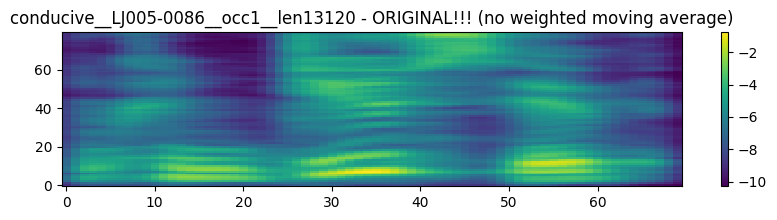

In [216]:
# plot GT mel spectrogram
token_id = list(token_id2fastpitch_gt_mel.keys())[0]
wordtype = token_id.split('__')[0]
gt_mel = token_id2fastpitch_gt_mel[token_id]

plot_melspec(gt_mel, token_id + " - ORIGINAL!!! (no weighted moving average)")

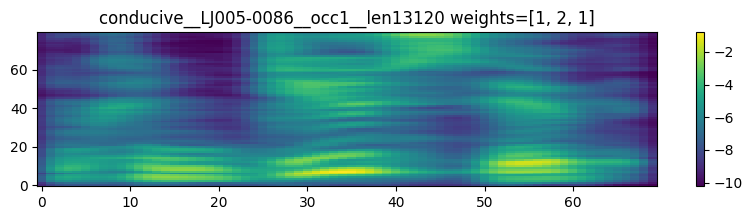

In [217]:
filter = [1,2,1]
wma = wma_smooth(gt_mel.T, weights=filter).T
plot_melspec(wma, token_id + f" weights={filter}")

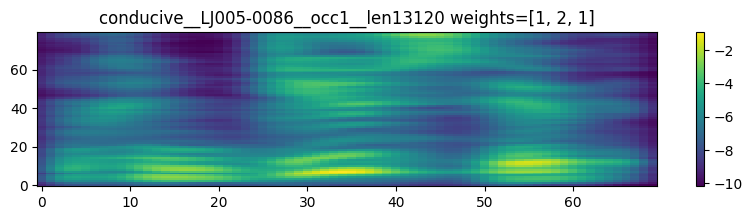

In [218]:
temporal_filter = [1,2,1]
feature_filter = [1,1,2,1,1]
wma = wma_smooth(gt_mel.T, dim_to_smooth=0, weights=temporal_filter).T
wma = wma_smooth(wma.T, dim_to_smooth=1, weights=feature_filter).T
plot_melspec(wma, token_id + f" weights={filter}")

conducive


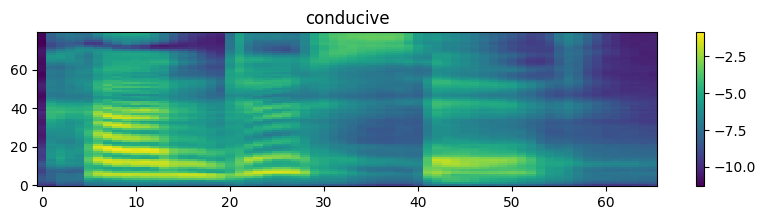

In [219]:
# plot predicted mel spectrogram
mel = spelling2tts_mel[wordtype]

print(wordtype)
plot_melspec(mel, wordtype)

# convert mel spec to Mel-Cepstrum then plot

In [220]:
def plot_mfcc(mfcc, extra_title=""):
    # assume mfcc is a numpy array of shape (n_mfcc, n_frames)
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap='coolwarm')
    plt.xlabel('Time')
    plt.ylabel('MFCC')
    title = 'MFCC'
    if extra_title:
        title += f": {extra_title}"
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

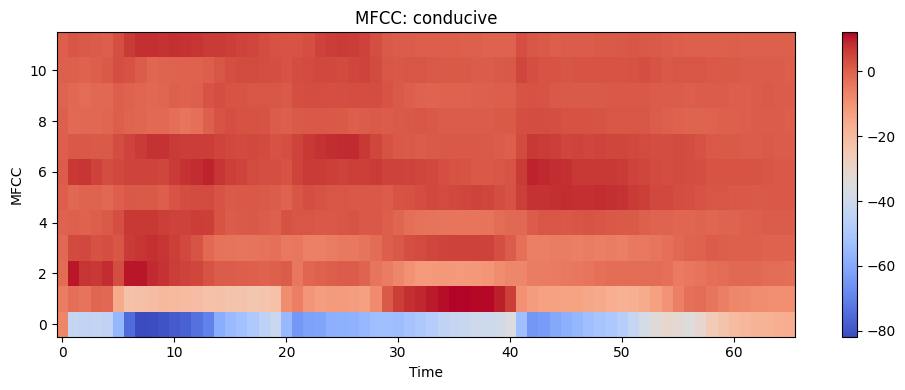

In [221]:
mfcc = melspec2mfcc(mel)
plot_mfcc(mfcc, wordtype)

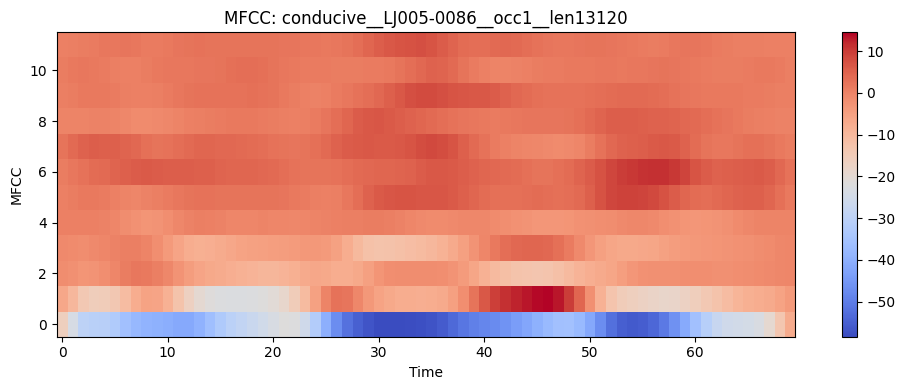

In [222]:
gt_mfcc = melspec2mfcc(gt_mel)
plot_mfcc(gt_mfcc, token_id)

# (optional) apply weighted moving average filters to GT mels

In [223]:
# temporal_filter = []
# feature_filter = []
temporal_filter = [1,2,1]
feature_filter = [1,1,2,1,1]

for token_id, fastpitch_gt_mel in token_id2fastpitch_gt_mel.items():
    if temporal_filter:
        fastpitch_gt_mel = wma_smooth(fastpitch_gt_mel.T, dim_to_smooth=0, weights=temporal_filter).T
    if feature_filter:
        fastpitch_gt_mel = wma_smooth(fastpitch_gt_mel.T, dim_to_smooth=1, weights=feature_filter).T    
        
    token_id2fastpitch_gt_mel[token_id] = fastpitch_gt_mel

# add acoustic distances between ground truth audio for word and synthesised respellings

compare ranking by:
- MCD-DTW
- SoftDTW
- L1, L2 distance

## Setup MCD-DTW and distance functions (e.g. euclidean, cosine, manhattan)

In [224]:
import mcd
from mcd import dtw
import sklearn
from scipy.spatial.distance import cosine
from numba import jit

def eucCost(x, y):
    """AKA l2 norm"""
    return math.sqrt(np.inner(x - y, x - y))

def manCost(x, y):
    """AKA l1 norm"""
    return np.sum(np.inner(x - y, x - y))

def cosineSim(x, y):
    """x and y are two single-timestep vectors"""
    # return torch.cosine_similarity(
    #     x.unsqueeze(2),
    #     self.label_embedding.weight.unsqueeze(0).unsqueeze(0),
    #     dim=-1,
    # )
    
    # TODO REPLACE THIS WITH NUMPY OPERATION TO SPEED UP???
    # distance = sklearn.metrics.pairwise.cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0]
    distance = cosine(x, y)
    
    # print("DEBUGcosineSim", distance, distance.shape)
    return distance

@jit(nopython=True)
def fastCosineSim(u,v):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
        
    return 1 - cos_theta 

import textdistance
norm_leven_dist = textdistance.Levenshtein()
# norm_leven_dist = textdistance.DamerauLevenshtein()

distance2costfn = {
    "euclidean": eucCost,
    "manhattan": manCost,
    "cosine": fastCosineSim,
}

feats_col2distance_types = {
    'mfcc': ['euclidean'],
    'hubert-raw': ['cosine'],
    'hubert-soft': ['cosine'],
    'hubert-discrete-code': ['levenshtein'],
    'hubert-discrete-centroid': ['cosine'],
}


## Calc DTW between synthesised speech representations and GT for all types of features and distance metrics)

In [225]:
def calc_sl_penalty(pred_len, gt_len):
    '''speech length mismatch penalty similar to MCD-DTW-SL
    encourages two sequences to be of same length
    M and N are length of each sequence
    coef = Max(M,N) / Min(M,N)'''
    coef = max(pred_len, gt_len) / min(pred_len, gt_len)
    return coef

In [226]:
df.columns

Index(['token_id', 'wordtype', 'respelling', 'cer', 'orig_wav', 'per', 'mfcc',
       'mfcc-GT', 'hubert-raw', 'hubert-raw-GT', 'hubert-soft',
       'hubert-soft-GT', 'hubert-discrete-code', 'hubert-discrete-code-GT',
       'hubert-discrete-centroid', 'hubert-discrete-centroid-GT',
       'mfcc::Distance(Euclidean)', 'mfcc::Distance(Euclidean)::w_SL_Penalty',
       'hubert-raw::Distance(Cosine)',
       'hubert-raw::Distance(Cosine)::w_SL_Penalty',
       'hubert-soft::Distance(Cosine)',
       'hubert-soft::Distance(Cosine)::w_SL_Penalty',
       'hubert-discrete-code::Distance(Levenshtein)',
       'hubert-discrete-code::Distance(Levenshtein)::w_SL_Penalty',
       'hubert-discrete-centroid::Distance(Cosine)',
       'hubert-discrete-centroid::Distance(Cosine)::w_SL_Penalty'],
      dtype='object')

In [227]:
feats_to_use

[('hubert', 'discrete', 'centroid')]

In [228]:
# calculate MCD-DTW distance for each synthesised respelling in the dataframe
# to the gt speech representation for the token_id that the respelling was generated from (using ASR)
    
for feats in feats_to_use:
    feat_type, *_ = feats
    feats_col, gt_feats_col = feats2feats_col(feats)
    
    for distance_type in feats_col2distance_types[feats_col]:
        distance_metric_col_name = f"{feats_col}::Distance({distance_type.title()})"
        print(f"Generating distances in '{distance_metric_col_name}'")

        for row_idx in tqdm(df.index):
            spelling = df.loc[row_idx, 'respelling']
            token_id = df.loc[row_idx, 'token_id']

            spelling_speech_rep = np.load(df.loc[row_idx, feats_col])
            gt_speech_rep = np.load(df.loc[row_idx, gt_feats_col])

            if 'code' in feats_col:
                distance_score = norm_leven_dist(gt_speech_rep.tolist(), 
                                                 spelling_speech_rep.tolist())
                gt_len = len(gt_speech_rep.tolist())
                spelling_len = len(spelling_speech_rep.tolist())
            else:
                distance_score, _path = dtw.dtw(gt_speech_rep.T, spelling_speech_rep.T, distance2costfn[distance_type])
                gt_len = gt_speech_rep.shape[1]
                spelling_len = spelling_speech_rep.shape[1]

            df.loc[row_idx, distance_metric_col_name] = distance_score
            
            # also add speech length penalty version of distance
            sl_pen_coef = calc_sl_penalty(spelling_len, gt_len)
            df.loc[row_idx, distance_metric_col_name + "::w_SL_Penalty"] = sl_pen_coef * distance_score

Generating distances in 'hubert-discrete-centroid::Distance(Cosine)'


100%|█████████████████████████████████████████████████████████| 246122/246122 [1:07:11<00:00, 61.05it/s]


In [229]:
# Cache dataframe to disk

save = True

if save:
    from datetime import datetime

    now = datetime.now()
    dt_string = now.strftime("%d-%b-%Y_%H:%M:%S")
    print("date and time =", dt_string)

    os.makedirs(os.path.join(os.getcwd(), 'results'), exist_ok=True)
    dataframe_outdir = os.path.join(os.getcwd(), 'results')
    dataframe_outpath = os.path.join(dataframe_outdir, f'distances_df_{dt_string}.pkl')
    df.to_pickle(dataframe_outpath)
    df = None

    # verify can load dataframe from disk
    def get_latest_file(in_dir, file_type):
        files = glob.glob(os.path.join(in_dir, file_type))
        return max(files, key=os.path.getctime)

    latest_file = get_latest_file(dataframe_outdir, r'*.pkl')

    df = pd.read_pickle(latest_file)
    print("Saved to disk @", latest_file)
else:
    print("WARNING DID NOT SAVE! INTENDED? BECAUSE OF DEBUGGING?")

date and time = 01-Apr-2023_13:05:28
Saved to disk @ /disk/nfs/ostrom/s1785140/rlspeller/results/distances_df_01-Apr-2023_13:05:28.pkl


In [230]:
df

,token_id,wordtype,respelling,cer,orig_wav,per,mfcc,mfcc-GT,hubert-raw,hubert-raw-GT,...,mfcc::Distance(Euclidean),mfcc::Distance(Euclidean)::w_SL_Penalty,hubert-raw::Distance(Cosine),hubert-raw::Distance(Cosine)::w_SL_Penalty,hubert-soft::Distance(Cosine),hubert-soft::Distance(Cosine)::w_SL_Penalty,hubert-discrete-code::Distance(Levenshtein),hubert-discrete-code::Distance(Levenshtein)::w_SL_Penalty,hubert-discrete-centroid::Distance(Cosine),hubert-discrete-centroid::Distance(Cosine)::w_SL_Penalty
0,conducive__LJ005-0086__occ1__len13120,conducive,toconducive,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/toconduci...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/toc...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,959.036613,1096.041843,16.546706,18.615045,8.664813,9.510160,18.0,19.756098,7.998631,8.778985
1,conducive__LJ005-0086__occ1__len13120,conducive,iconducived,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/iconduciv...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/ico...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1239.246208,1487.095449,22.935356,26.949043,14.554462,17.039370,27.0,31.609756,13.316780,15.590376
2,conducive__LJ005-0086__occ1__len13120,conducive,heconducivedd,44.444444,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/heconduci...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/hec...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1204.564791,1393.853544,28.895824,33.230198,22.590723,25.345689,34.0,38.146341,15.366240,17.240172
3,conducive__LJ005-0086__occ1__len13120,conducive,consducived,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/consduciv...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/con...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1418.388920,1843.905596,25.977098,33.120800,16.232254,20.587249,27.0,34.243902,13.548413,17.183353
4,conducive__LJ005-0086__occ1__len13120,conducive,conducivevd,22.222222,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/mfcc/conducive...,/home/s1785140/rlspeller/caches/hubert/raw/con...,/home/s1785140/rlspeller/caches/hubert/raw/con...,...,1462.096628,1754.515954,27.436162,32.237491,22.598137,26.456356,38.0,44.487805,19.251346,22.538161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246117,peripheral__LJ031-0066__occ1__len8960,peripheral,peripheral,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.571429,/home/s1785140/rlspeller/caches/mfcc/periphera...,/home/s1785140/rlspeller/caches/mfcc/periphera...,/home/s1785140/rlspeller/caches/hubert/raw/per...,/home/s1785140/rlspeller/caches/hubert/raw/per...,...,1023.208512,1279.010640,16.703627,21.034196,13.484816,16.374420,27.0,32.785714,15.759090,19.136038
246118,righteous__LJ012-0066__occ1__len9920,righteous,righteous,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.400000,/home/s1785140/rlspeller/caches/mfcc/righteous...,/home/s1785140/rlspeller/caches/mfcc/righteous...,/home/s1785140/rlspeller/caches/hubert/raw/rig...,/home/s1785140/rlspeller/caches/hubert/raw/rig...,...,937.891513,1167.940375,17.504982,21.589477,15.119244,18.045549,24.0,28.645161,8.485674,10.128062
246119,exhaustive__LJ006-0027__occ1__len11040,exhaustive,exhaustive,0.000000,/home/s1785140/speechbrain/templates/speech_re...,0.500000,/home/s1785140/rlspeller/caches/mfcc/exhaustiv...,/home/s1785140/rlspeller/caches/mfcc/exhaustiv...,/home/s1785140/rlspeller/caches/hubert/raw/exh...,/home/s1785140/rlspeller/caches/hubert/raw/exh...,...,813.416527,923.710294,14.838180